SnowCV method to quantify snow height from phenocam staff gauge imagery.
For NEON Battelle
Donal O'Leary
April 12 2021

Borrowing liberally from <a href="https://www.pyimagesearch.com/2017/07/17/credit-card-ocr-with-opencv-and-python/" target="_blank">this awesome tutorial by Adrian Rosebrock</a>.

In [1]:
import cv2
import glob
import ntpath
import imutils
from imutils import contours
import argparse
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import numpy as np
import pandas as pd
from datetime import date
import datetime
%matplotlib inline

## Working with an Example Phenocam Image
For this next section, we will work with a single phenocam image to see if we can identify the digits that are on the staff gauge.

In [2]:
plt.rcParams['figure.figsize'] = [15, 15] # set plot size

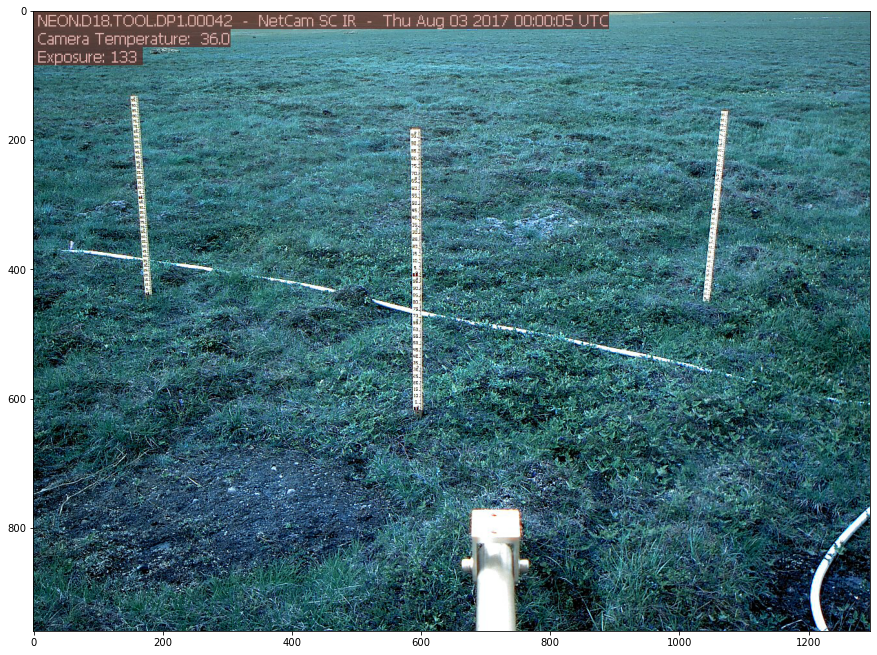

In [11]:
cal = cv2.imread('/Users/olearyd/Git/SnowCV/data/TOOL_gauge_calibration_bare_ground.jpg')
plt.imshow(cal)

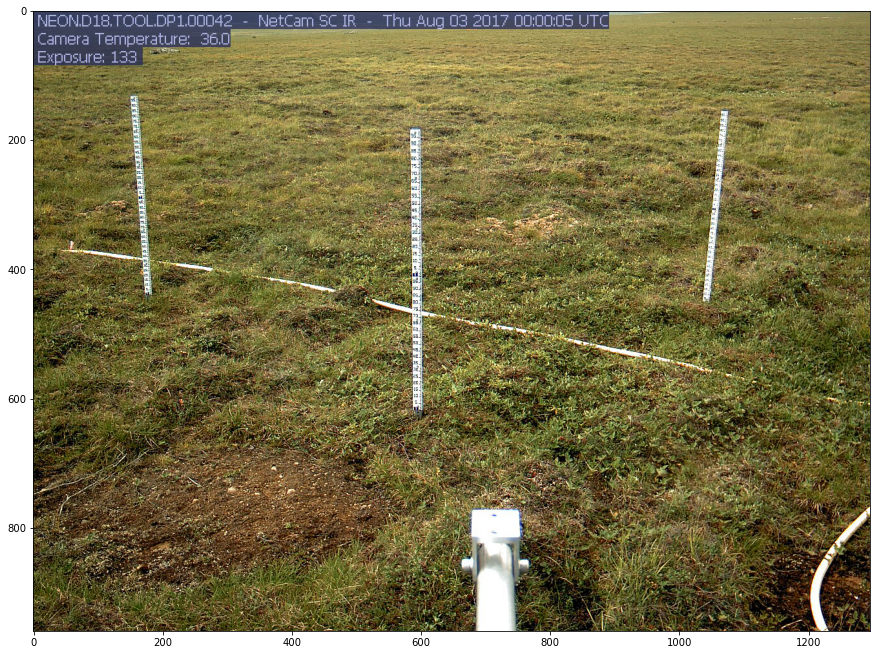

In [12]:
cal = cv2.cvtColor(cal, cv2.COLOR_BGR2RGB)
# Note that if you run this cell multiple times, it will keep reversing the colors! 
plt.imshow(cal)

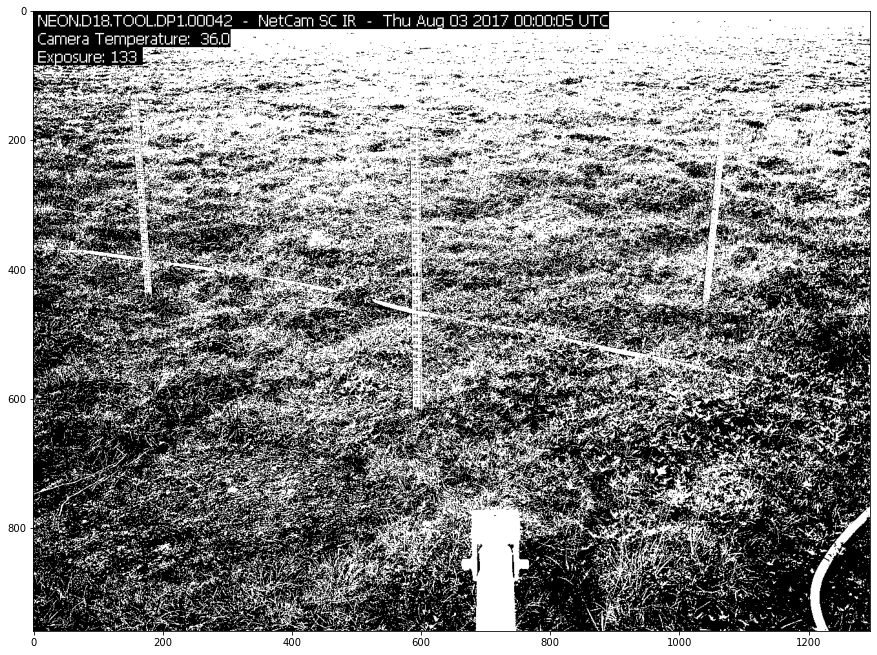

In [13]:
cal = cv2.cvtColor(cal, cv2.COLOR_RGB2GRAY)
cal = cv2.threshold(cal, 100, 255, cv2.THRESH_BINARY)[1]
plt.imshow(cal, cmap='gray')

Now we must make a very precise bounding box around the staff gauge - this will be our 'ground truth' staff gauge length representing of zero snow.

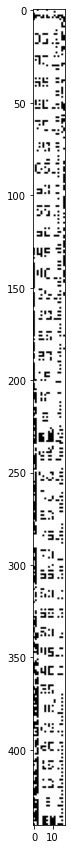

In [65]:
cal_gauge = cal[177:618,585:602]
plt.imshow(cal_gauge, cmap='gray')

In [66]:
gauge_height = cal_gauge.shape[0] # height in pixels
gauge_height

441

According to this image, the staff gauge has 438 visible pixels across its 2m height. We will use this to compare against subsequent images to deterrmine how deep the snow is!

## Working with a snowy Phenocam Image

In [19]:
## Update this to grob all files from direectory
fn = '/Users/olearyd/Git/SnowCV/data/NEON.D18.TOOL.DP1.00042_2017_03_13_150005.jpg'

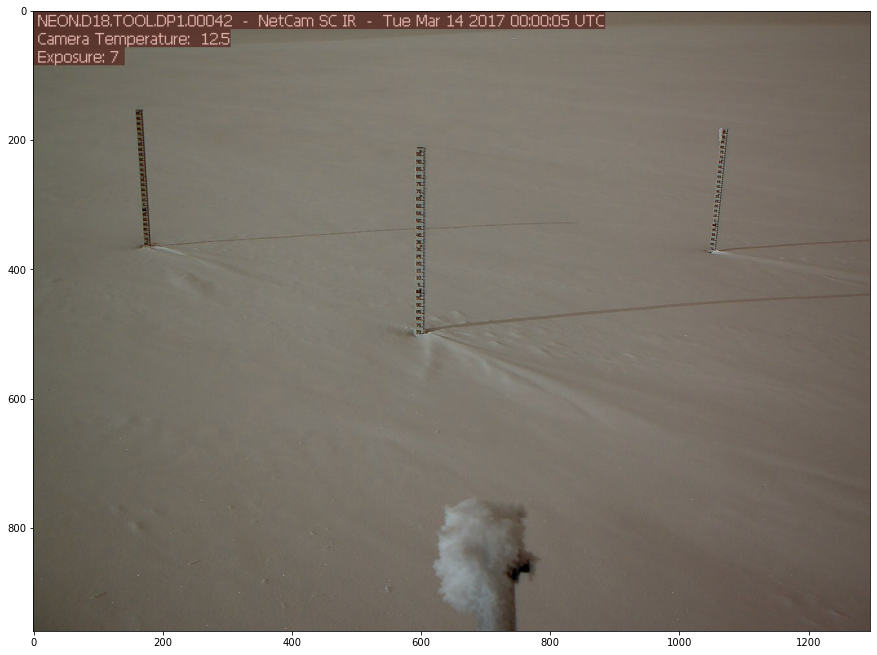

In [31]:
ref = cv2.imread(fn)
plt.rcParams['figure.figsize'] = [15, 15] # set plot size
plt.imshow(ref)

However, there is a problem here! The blue and red channels are reversed because `cv2.imread()` uses BGR as the default, whereas .jpg files are written in RGB order. So we can rearrange the channels and plot again.

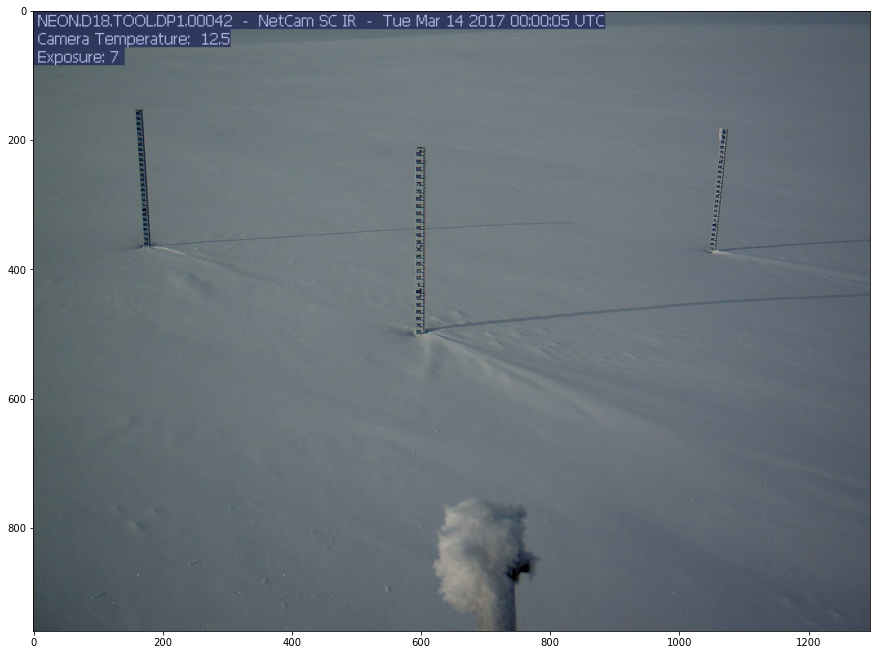

In [32]:
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
# Note that if you run this cell multiple times, it will keep reversing the colors! 
plt.imshow(ref)

In any case, it is best practice to convert the three-color-channel image to a grayscale image for further processing. So we will convert this RGB image to Gray using the `cv2.cvtColor()` function with the `cv2.COLOR_RGB2GRAY` argument.

In [33]:

ref = cv2.cvtColor(ref, cv2.COLOR_RGB2GRAY)
ref = cv2.threshold(ref, 50, 255, cv2.THRESH_BINARY)[1]
#ref = cv2.adaptiveThreshold(ref,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,2)
ref

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

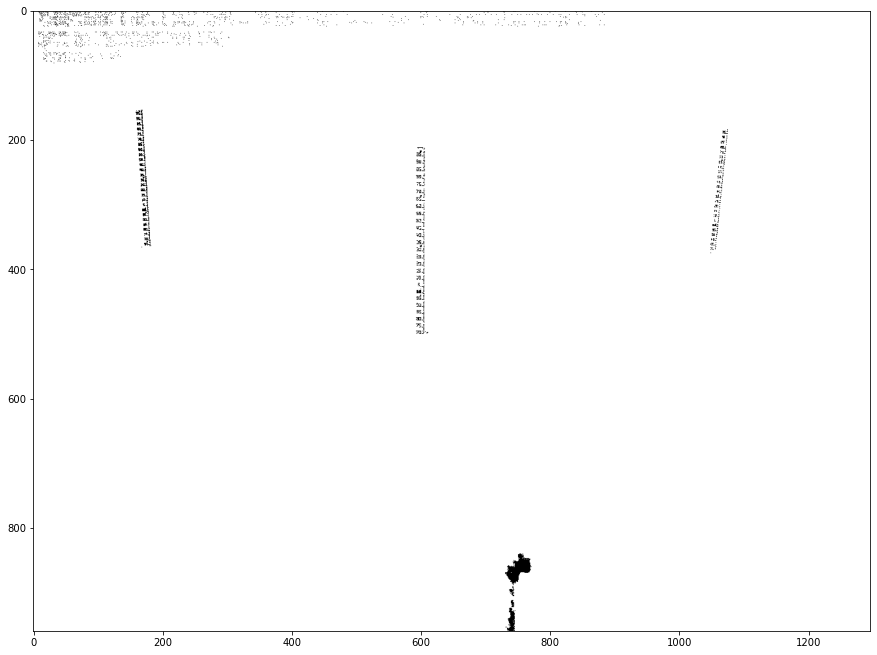

In [34]:
plt.imshow(ref, cmap='gray')

In [37]:
#ROI = ref[335:825,735:755]
ROI = ref[175:620,585:610]

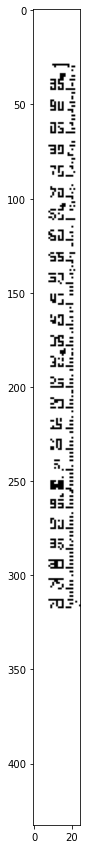

In [38]:
#plt.rcParams['figure.figsize'] = [5, 15]
plt.imshow(ROI,cmap='gray')

Now, let's see if we can blur the image into a single bar and measure its length

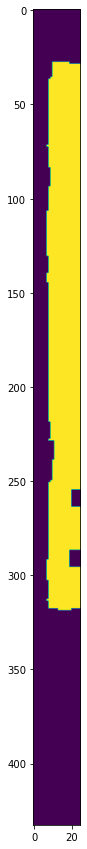

In [39]:
kernel = np.ones((5,5),np.uint8)
ROI_bar = cv2.Canny(ROI.copy() , 10, 255)
ROI_bar = cv2.dilate(ROI_bar, kernel, iterations = 2)
ROI_bar = cv2.erode(ROI_bar, kernel, iterations = 2)
#ROI_bar = ROI.copy()
plt.imshow(ROI_bar)

In [40]:
templateCnts = cv2.findContours(ROI_bar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
templateCnts = imutils.grab_contours(templateCnts)
templateCnts = contours.sort_contours(templateCnts, method="left-to-right")[0]

In [41]:
len(templateCnts)

1

In [42]:
bb_heights = []
for (i, c) in enumerate(templateCnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    bb_heights.append(h)

visible_gauge = max(bb_heights)
print(visible_gauge)

291


Now that we have a length of the visible staff gauge text and markers, we can subtract that length from the total length of the staff gauge with no snow present, and divide by the number of pixels per meter to find meters of snow!

In [43]:
(gauge_height - visible_gauge)/gauge_height*200

65.58891454965358

## Phenocam Movement
Unfortunately, this phenocam at NIWO has moved some over time. On October 08, 2019, at approximately 12:05 Colorado time, the phenocam was moved slightly, which means that we must change the ROI for the gaguge after this point.

Another issue is that one of the instrument booms was in the field of view for the phenocam prior to May 9, 2017, which obscures the bottom of the staff gauge.

For now, let's just look at data between those two dates.

In [44]:
files = sorted(glob.glob('/Users/olearyd/Downloads/phenocamdata_TOOL/NEON.D18.TOOL.DP1.00042/**/*.jpg', recursive=True))
files

['/Users/olearyd/Downloads/phenocamdata_TOOL/NEON.D18.TOOL.DP1.00042/2017/02/NEON.D18.TOOL.DP1.00042_2017_02_25_150006.jpg',
 '/Users/olearyd/Downloads/phenocamdata_TOOL/NEON.D18.TOOL.DP1.00042/2017/02/NEON.D18.TOOL.DP1.00042_2017_02_26_150005.jpg',
 '/Users/olearyd/Downloads/phenocamdata_TOOL/NEON.D18.TOOL.DP1.00042/2017/02/NEON.D18.TOOL.DP1.00042_2017_02_27_150006.jpg',
 '/Users/olearyd/Downloads/phenocamdata_TOOL/NEON.D18.TOOL.DP1.00042/2017/02/NEON.D18.TOOL.DP1.00042_2017_02_28_150005.jpg',
 '/Users/olearyd/Downloads/phenocamdata_TOOL/NEON.D18.TOOL.DP1.00042/2017/03/NEON.D18.TOOL.DP1.00042_2017_03_05_150005.jpg',
 '/Users/olearyd/Downloads/phenocamdata_TOOL/NEON.D18.TOOL.DP1.00042/2017/03/NEON.D18.TOOL.DP1.00042_2017_03_06_150006.jpg',
 '/Users/olearyd/Downloads/phenocamdata_TOOL/NEON.D18.TOOL.DP1.00042/2017/03/NEON.D18.TOOL.DP1.00042_2017_03_07_150005.jpg',
 '/Users/olearyd/Downloads/phenocamdata_TOOL/NEON.D18.TOOL.DP1.00042/2017/03/NEON.D18.TOOL.DP1.00042_2017_03_08_150006.jpg',


In [45]:
for f in range(len(files)):
    bn = ntpath.basename(files[f])
    l = bn.split('_')
    print(l[1] +','+ l[2] +','+ l[3]+','+l[4][0:6])
    #print(ntpath.basename(files[f]))

2017,02,25,150006
2017,02,26,150005
2017,02,27,150006
2017,02,28,150005
2017,03,05,150005
2017,03,06,150006
2017,03,07,150005
2017,03,08,150006
2017,03,09,150006
2017,03,10,150005
2017,03,11,150006
2017,03,12,150005
2017,03,13,150005
2017,03,14,150005
2017,03,15,150006
2017,03,16,150005
2017,03,17,150005
2017,03,18,150006
2017,03,19,150006
2017,03,20,150006
2017,03,27,150006
2017,03,28,150006
2017,03,29,150006
2017,03,30,150005
2017,03,31,150006
2017,04,01,150006
2017,04,02,150005
2017,04,03,150006
2017,04,04,150005
2017,04,05,150005
2017,04,06,150005
2017,04,07,150006
2017,04,08,150005
2017,04,09,150005
2017,04,10,150006
2017,04,11,150005
2017,04,12,150006
2017,04,13,150006
2017,04,14,150006
2017,04,15,150006
2017,04,16,150006
2017,04,17,150005
2017,04,18,150006
2017,04,19,150006
2017,04,20,150005
2017,04,21,150006
2017,04,22,150005
2017,04,23,150006
2017,04,24,150005
2017,04,25,150005
2017,04,26,150006
2017,04,27,150006
2017,04,29,150005
2017,04,30,150006
2017,05,01,150006
2017,05,02

In [126]:
def snow_depth_from_img(img, g_height):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,10)
    #img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)[1]
    #img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,2)
    img_ROI = img[175:620,570:680]
    #img_ROI = img[330:830,675:730] # What if we make the ROI larger
    kernel = np.ones((5,5),np.uint8)
    img_ROI_bar = cv2.Canny(img_ROI.copy() , 10, 255)
    img_ROI_bar = cv2.dilate(img_ROI_bar, kernel, iterations = 2)
    img_ROI_bar = cv2.erode(img_ROI_bar, kernel, iterations = 2)
    
    # Get contours of shape
    img_Cnts = cv2.findContours(img_ROI_bar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_Cnts = imutils.grab_contours(img_Cnts)
    
    # There may be multiple contours due to noise or a smudge on the gauge, 
    # so find the height of the tallest one to compare against gauge height
    img_bb_heights = []
    for (i, c) in enumerate(img_Cnts):
        # compute the bounding box for the digit, extract it, and resize
        # it to a fixed size
        (x, y, w, h) = cv2.boundingRect(c)
        img_bb_heights.append(h)

    if len(img_bb_heights)==0:
        visible_gauge = 9999
    else:
        visible_gauge = max(img_bb_heights)
    
    # Calculate depth of snow
    DOS = (g_height - visible_gauge)/g_height*200
    
    return DOS


In [127]:
snow_depth_from_img(files[0], gauge_height)
# Should be about 14cm

44.44444444444444

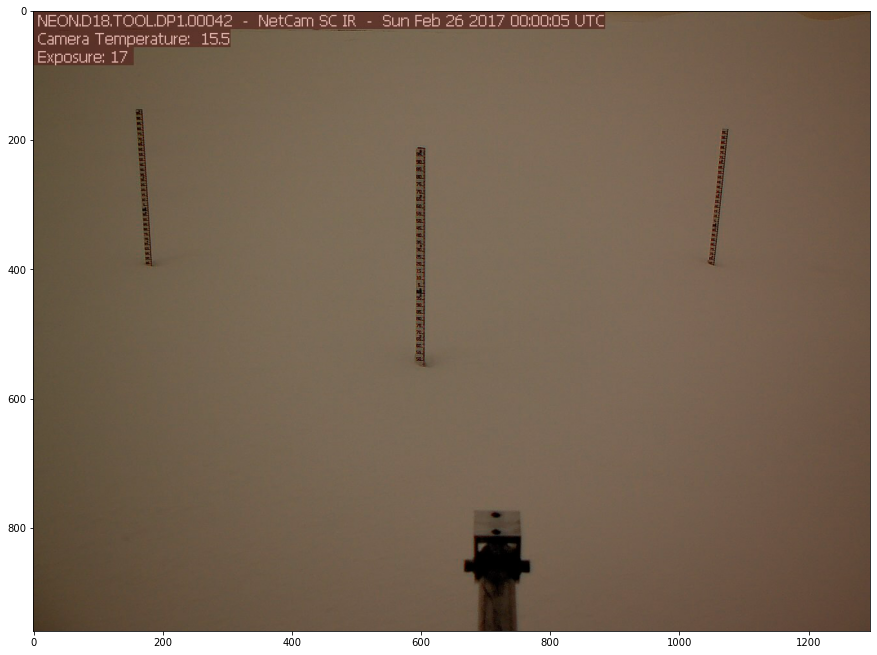

In [128]:
plt.imshow(cv2.imread(files[0]))

In [129]:
## Depth of Snow for all images
df = pd.DataFrame(columns=['img_number', 'year', 'month','day','time','snow_depth'])
for f in range(len(files)):
    bn = ntpath.basename(files[f])
    l = bn.split('_')
    d = snow_depth_from_img(files[f], gauge_height)
    row = [f,int(l[1]),int(l[2]),int(l[3]),int(l[4][0:6]),d]
    df.loc[f]=row
    #print(row)

In [130]:
#df['date']=date(df.year.astype(str).astype(int)) #, df.month.astype(str).astype(int), df.day.astype(str).astype(int)
#df['date']=date(df.year.astype(int), df.month.astype(int), df.day.astype(int))
#df.dtypes
#df.year.astype(int)
#df = df.astype({"img_number":int ,"year": int, "month": int, "day": int, "time": int})
sd = df.snow_depth
df = df.astype(int)
df.dtypes
#df['date']= df.apply(lambda x:datetime.datetime.strptime("{0} {1} {2}".format(x['year'],x['month'], x['day']), "%Y %m %d"),axis=1)
#df.index= df['date']

img_number    int64
year          int64
month         int64
day           int64
time          int64
snow_depth    int64
dtype: object

In [131]:
df['date']= df.apply(lambda df: datetime.date(df['year'], df['month'], df['day']), axis=1)
#df.dtypes
#df['date']= df.apply(lambda x:datetime.datetime.strptime("{0} {1} {2}".format(x['year'],x['month'], x['day']), "%Y %m %d"),axis=1)
#df['date']= df.apply(lambda x:datetime.datetime.strptime("{x['year']:.0f} {x['month']:2.0f} {x['day']:2.0f}", "%Y %m %d"),axis=1)
df.snow_depth = sd


In [148]:
pd.set_option('display.max_rows', 1200)
df

img_number  year  month  day    time  snow_depth        date
0              0  2017      2   25  150006   44.444444  2017-02-25
1              1  2017      2   26  150005   48.526077  2017-02-26
2              2  2017      2   27  150006   48.526077  2017-02-27
3              3  2017      2   28  150005    9.070295  2017-02-28
4              4  2017      3    5  150005   17.687075  2017-03-05
6              6  2017      3    7  150005   36.281179  2017-03-07
7              7  2017      3    8  150006   26.303855  2017-03-08
8              8  2017      3    9  150006   63.038549  2017-03-09
9              9  2017      3   10  150005   64.399093  2017-03-10
10            10  2017      3   11  150006   66.213152  2017-03-11
11            11  2017      3   12  150005   66.666667  2017-03-12
12            12  2017      3   13  150005   59.410431  2017-03-13
13            13  2017      3   14  150005   54.875283  2017-03-14
14            14  2017      3   15  150006   13.605442  2017-03-15
15            15  2017      3   16  150005   14.058957  2017-03-16
16            16  2017      3   17  150005   13.605442  2017-03-17
17            17  2017      3   18  150006   10.430839  2017-03-18
18            18  2017      3   19  150006   14.058957  2017-03-19
19            19  2017      3   20  150006    3.628118  2017-03-20
20            20  2017      3   27  150006   50.793651  2017-03-27
21            21  2017      3   28  150006   62.585034  2017-03-28
22            22  2017      3   29  150006   63.038549  2017-03-29
23            23  2017      3   30  150005   62.585034  2017-03-30
24            24  2017      3   31  150006   52.154195  2017-03-31
25            25  2017      4    1  150006   61.678005  2017-04-01
26            26  2017      4    2  150005   48.072562  2017-04-02
27            27  2017      4    3  150006   61.224490  2017-04-03
28            28  2017      4    4  150005   39.002268  2017-04-04
30            30  2017      4    6  150005   17.233560  2017-04-06
31            31  2017      4    7  150006   14.058957  2017-04-07
33            33  2017      4    9  150005   19.954649  2017-04-09
34            34  2017      4   10  150006   22.222222  2017-04-10
35            35  2017      4   11  150005   20.861678  2017-04-11
36            36  2017      4   12  150006    5.895692  2017-04-12
37            37  2017      4   13  150006    9.070295  2017-04-13
38            38  2017      4   14  150006   38.095238  2017-04-14
39            39  2017      4   15  150006   49.886621  2017-04-15
40            40  2017      4   16  150006   54.421769  2017-04-16
41            41  2017      4   17  150005   54.421769  2017-04-17
42            42  2017      4   18  150006   54.421769  2017-04-18
43            43  2017      4   19  150006   56.235828  2017-04-19
44            44  2017      4   20  150005   39.909297  2017-04-20
45            45  2017      4   21  150006   54.421769  2017-04-21
46            46  2017      4   22  150005   55.328798  2017-04-22
47            47  2017      4   23  150006   51.700680  2017-04-23
48            48  2017      4   24  150005   54.875283  2017-04-24
49            49  2017      4   25  150005   56.689342  2017-04-25
50            50  2017      4   26  150006   53.061224  2017-04-26
51            51  2017      4   27  150006   40.816327  2017-04-27
52            52  2017      4   29  150005   51.700680  2017-04-29
53            53  2017      4   30  150006   51.700680  2017-04-30
54            54  2017      5    1  150006   46.258503  2017-05-01
55            55  2017      5    2  150006   40.362812  2017-05-02
56            56  2017      5    3  150005   51.700680  2017-05-03
57            57  2017      5    4  150005   59.410431  2017-05-04
58            58  2017      5    5  150005   17.687075  2017-05-05
59            59  2017      5    6  150005   20.861678  2017-05-06
60            60  2017      5    7  150005    4.988662  2017-05-07
61            61  2017      5    8  150006   53.06122

In [133]:
df=df[df['snow_depth'] >= 0]
#df=df[df['snow_depth'] <= 70]

<AxesSubplot:xlabel='date'>

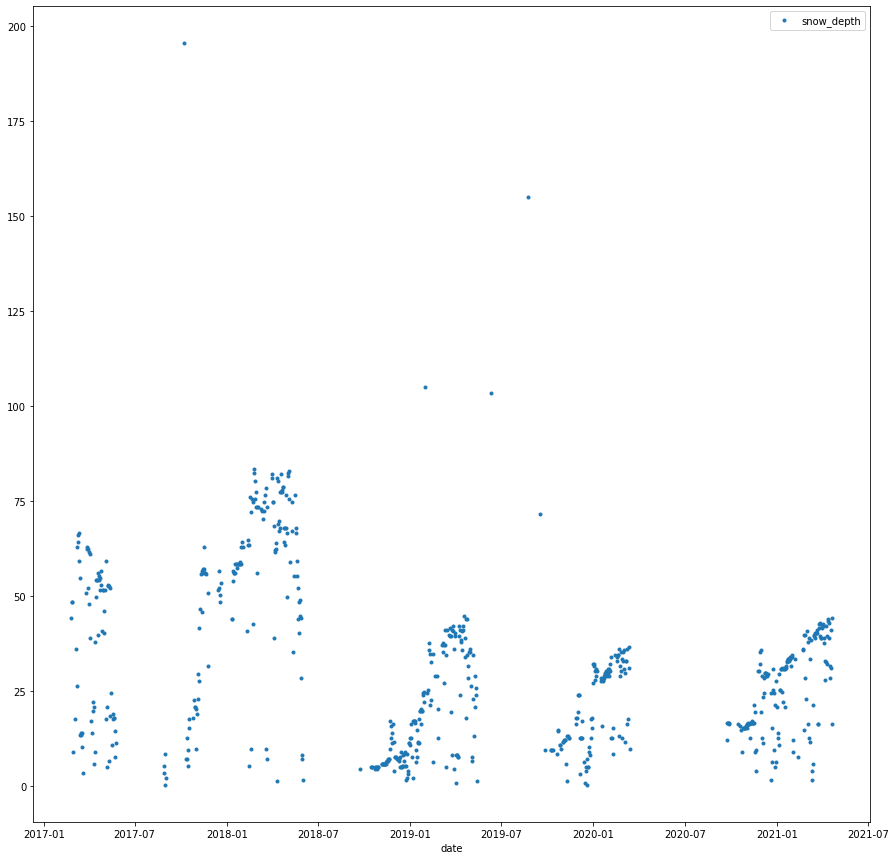

In [147]:
df.plot(x="date", y="snow_depth", style=".")

In [160]:
def check_img(number):
    plt.rcParams['figure.figsize'] = [15, 15] # set plot size
    figure, ax = plt.subplots(3,figsize=(15,15))
    #print(figure)
    img = cv2.imread(files[number])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rect = matplotlib.patches.Rectangle((585,175),(680-585),(620-175), edgecolor='r', facecolor="none")
    ax[0].imshow(img)
    ax[0].add_patch(rect)
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)[1]
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,10)
    #[335:825,690:715]
    rect = matplotlib.patches.Rectangle((585,175),(680-585),(620-175), edgecolor='r', facecolor="none")

    
    # Plot CV process
    kernel = np.ones((5,5),np.uint8)
    img_ROI = img[175:620,585:680]
    img_ROI_bar = cv2.Canny(img_ROI.copy() , 10, 255)
    img_ROI_bar = cv2.dilate(img_ROI_bar, kernel, iterations = 2)
    img_ROI_bar = cv2.erode(img_ROI_bar, kernel, iterations = 2)
    #print(type(img_ROI_bar))
    
    #figure2, ax2 = plt.subplots(2)    
    
    # Get contours of shape
    img_Cnts = cv2.findContours(img_ROI_bar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_Cnts = imutils.grab_contours(img_Cnts)
    
    # There may be multiple contours due to noise or a smudge on the gauge, 
    # so find the height of the tallest one to compare against gauge height
    img_bbs = []
    img_bb_heights = []
    for (i, c) in enumerate(img_Cnts):
        # compute the bounding box for the digit, extract it, and resize
        # it to a fixed size
        (x, y, w, h) = cv2.boundingRect(c)
        img_bb_heights.append(h)
        ### Need to pick tallest container here! ###
        box = [x,y,w,h]
        img_bbs.append(box)
        
    ind = img_bb_heights.index(max(img_bb_heights))
       
    box = img_bbs[ind]    
        
    rect2 = matplotlib.patches.Rectangle((box[0],box[1]),box[2],box[3], edgecolor='g', facecolor="none", linewidth = 2)
    rect2_adj = matplotlib.patches.Rectangle((box[0]+585,box[1]+175),box[2],box[3], edgecolor='g', facecolor="none", linewidth = 2)

    # plot the grayscale image with search window and visible gauge rectangles
    
    patches = []
    patches.append(rect)
    patches.append(rect2_adj)
    ax[1].imshow(img, cmap='gray')
    ax[1].add_collection(matplotlib.collections.PatchCollection(patches, match_original=True))
    #ax[1].add_patch(rect2)
    
    # plot the visible staff gauge as found by the algorithm
    ax[2].imshow(img_ROI_bar, cmap='gray')
    ax[2].add_patch(rect2)

#     if len(img_bb_heights)==0:
#         visible_gauge = 9999
#     else:
#         visible_gauge = max(img_bb_heights)
    
    return 

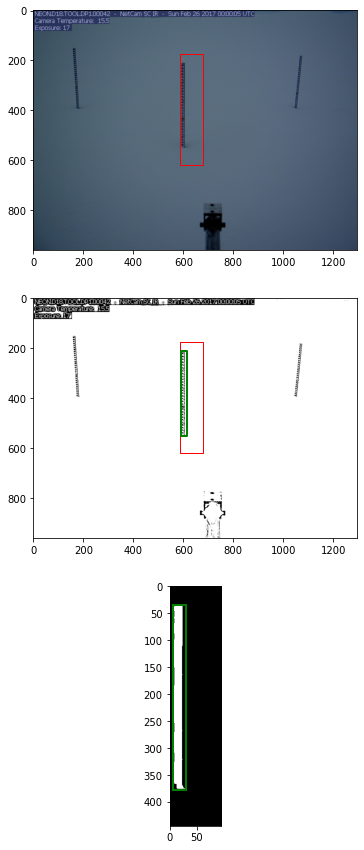

In [161]:
check_img(0)

In [ ]:

plt.rcParams['figure.figsize'] = [15, 15] # set plot size
img = matplotlib.image.imread(files[0])

figure, ax = plt.subplots(1)

#[335:825,690:715]
rect = matplotlib.patches.Rectangle((690,335),(780-675),(825-335), edgecolor='r', facecolor="none")

ax.imshow(img)


ax.add_patch(rect)

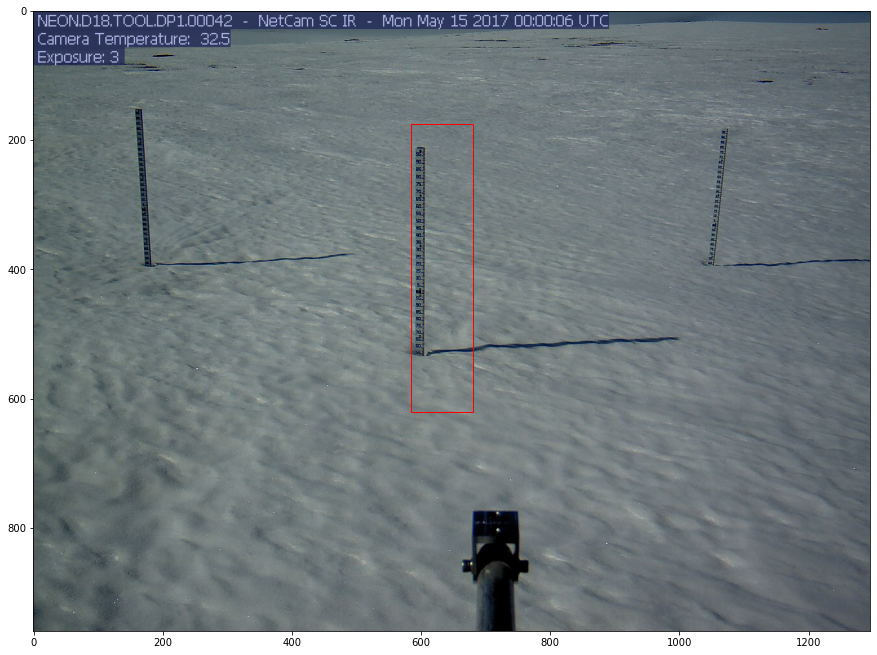

In [176]:
number=67
plt.rcParams['figure.figsize'] = [15, 15] # set plot size
figure, ax = plt.subplots(1,figsize=(15,15))
#print(figure)
img = cv2.imread(files[number])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rect = matplotlib.patches.Rectangle((585,175),(680-585),(620-175), edgecolor='r', facecolor="none")
ax.imshow(img)
ax.add_patch(rect)

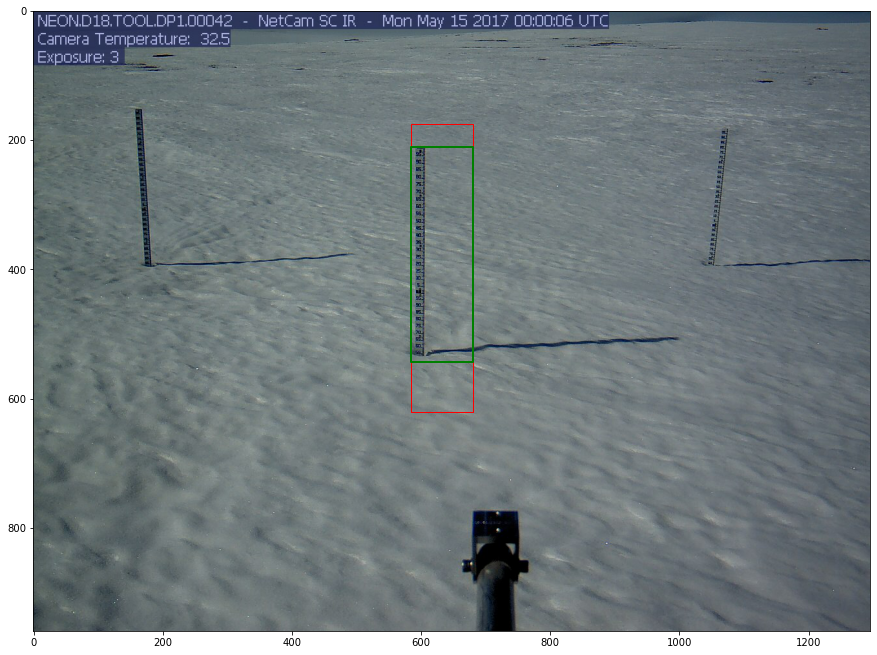

In [177]:
# Plot CV process
figure, ax = plt.subplots(1,figsize=(15,15))
kernel = np.ones((5,5),np.uint8)
img_ROI = img[175:620,585:680]
img_ROI_bar = cv2.Canny(img_ROI.copy() , 10, 255)
img_ROI_bar = cv2.dilate(img_ROI_bar, kernel, iterations = 2)
img_ROI_bar = cv2.erode(img_ROI_bar, kernel, iterations = 2)
#print(type(img_ROI_bar))

#figure2, ax2 = plt.subplots(2)    

# Get contours of shape
img_Cnts = cv2.findContours(img_ROI_bar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_Cnts = imutils.grab_contours(img_Cnts)

# There may be multiple contours due to noise or a smudge on the gauge, 
# so find the height of the tallest one to compare against gauge height
img_bbs = []
img_bb_heights = []
for (i, c) in enumerate(img_Cnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    img_bb_heights.append(h)
    ### Need to pick tallest container here! ###
    box = [x,y,w,h]
    img_bbs.append(box)

ind = img_bb_heights.index(max(img_bb_heights))

box = img_bbs[ind]    

rect = matplotlib.patches.Rectangle((585,175),(680-585),(620-175), edgecolor='r', facecolor="none")
rect2 = matplotlib.patches.Rectangle((box[0],box[1]),box[2],box[3], edgecolor='g', facecolor="none", linewidth = 2)
rect2_adj = matplotlib.patches.Rectangle((box[0]+585,box[1]+175),box[2],box[3], edgecolor='g', facecolor="none", linewidth = 2)

# plot the grayscale image with search window and visible gauge rectangles

patches = []
patches.append(rect)
patches.append(rect2_adj)
ax.imshow(img, cmap='gray')
ax.add_collection(matplotlib.collections.PatchCollection(patches, match_original=True))

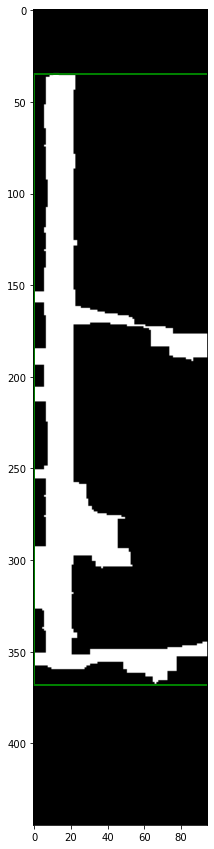

In [178]:
figure, ax = plt.subplots(1,figsize=(15,15))
kernel = np.ones((5,5),np.uint8)
img_ROI = img[175:620,585:680]
img_ROI_bar = cv2.Canny(img_ROI.copy() , 10, 255)
img_ROI_bar = cv2.dilate(img_ROI_bar, kernel, iterations = 2)
img_ROI_bar = cv2.erode(img_ROI_bar, kernel, iterations = 2)
#print(type(img_ROI_bar))

#figure2, ax2 = plt.subplots(2)    

# Get contours of shape
img_Cnts = cv2.findContours(img_ROI_bar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_Cnts = imutils.grab_contours(img_Cnts)

# There may be multiple contours due to noise or a smudge on the gauge, 
# so find the height of the tallest one to compare against gauge height
img_bbs = []
img_bb_heights = []
for (i, c) in enumerate(img_Cnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    img_bb_heights.append(h)
    ### Need to pick tallest container here! ###
    box = [x,y,w,h]
    img_bbs.append(box)

ind = img_bb_heights.index(max(img_bb_heights))

box = img_bbs[ind]    

rect = matplotlib.patches.Rectangle((585,175),(680-585),(620-175), edgecolor='r', facecolor="none")
rect2 = matplotlib.patches.Rectangle((box[0],box[1]),box[2],box[3], edgecolor='g', facecolor="none", linewidth = 2)
rect2_adj = matplotlib.patches.Rectangle((box[0]+585,box[1]+175),box[2],box[3], edgecolor='g', facecolor="none", linewidth = 2)

# plot the grayscale image with search window and visible gauge rectangles

patches = []
patches.append(rect)
patches.append(rect2_adj)
ax.imshow(img_ROI_bar, cmap='gray')
ax.add_patch(rect2)